In [1]:
# 📘 Multiple Linear Regression (OLS) with Feature Selection & Deployment
# Dataset: car-mpg.csv

In [2]:
## Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
## Step 2: Load the Dataset
df = pd.read_csv(r'C:\Users\USER\Documents\Python\Nareshit data analysis\stats and ML\ML\27th- l1, l2, scaling\lasso, ridge, elastic net\TASK-22_LASSO,RIDGE\car-mpg.csv')
df.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_type,car_name
0,18.0,8,307.0,130,3504,12,70,1,0,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,0,buick skylark 320
2,18.0,8,318.0,150,3436,11,70,1,0,plymouth satellite
3,16.0,8,304.0,150,3433,12,70,1,0,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,0,ford torino


In [4]:
## Step 3: Basic EDA
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mpg       398 non-null    float64
 1   cyl       398 non-null    int64  
 2   disp      398 non-null    float64
 3   hp        398 non-null    object 
 4   wt        398 non-null    int64  
 5   acc       398 non-null    object 
 6   yr        398 non-null    object 
 7   origin    398 non-null    int64  
 8   car_type  398 non-null    int64  
 9   car_name  398 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 31.2+ KB


mpg         0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
origin      0
car_type    0
car_name    0
dtype: int64

In [5]:
## Step 4: Feature Selection and Preprocessing
# Drop irrelevant columns
df.drop(['car_name'], axis=1, inplace=True)

In [7]:
# Find out if any cell contains any discrepancy, ie, unwanted special characters.
import re

def find_special_chars(series):
    return series[series.astype(str).str.contains(r'[^a-zA-Z0-9\s.]', regex=True, na=False)]

# Check each column
special_chars_found = {col: find_special_chars(df[col]) for col in df.columns}

# Display results
for col, values in special_chars_found.items():
    if not values.empty:
        print(f"Column '{col}' contains special characters in the following rows:")
        print(values, "\n")

Column 'hp' contains special characters in the following rows:
32     ?
126    ?
330    ?
336    ?
354    ?
374    ?
Name: hp, dtype: object 

Column 'acc' contains special characters in the following rows:
28    18.5!
Name: acc, dtype: object 

Column 'yr' contains special characters in the following rows:
34    !71
Name: yr, dtype: object 



In [9]:
df = df.replace(r'[?!]', "", regex=True).replace(r'^\s*$', np.nan, regex=True)

In [10]:
df.isnull().sum()

mpg         0
cyl         0
disp        0
hp          6
wt          0
acc         0
yr          0
origin      0
car_type    0
dtype: int64

In [12]:
df['hp'] = df['hp'].fillna(np.mean(pd.to_numeric(df['hp'])))

In [13]:
df['origin'] = df['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})
df = pd.get_dummies(df, columns=['origin'],dtype=int)

<Axes: >

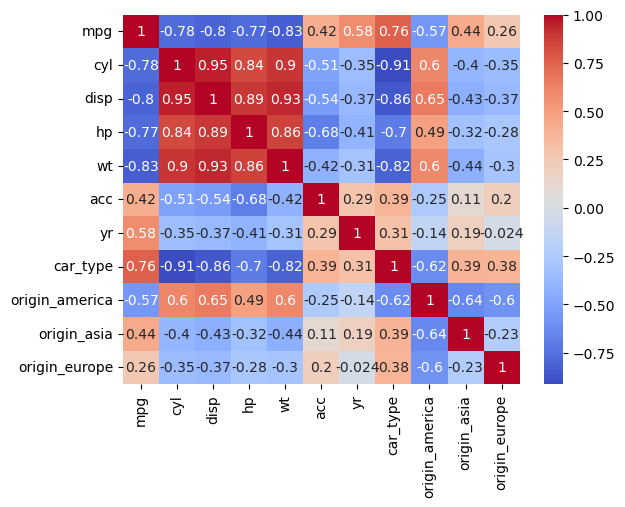

In [14]:
# Check correlation
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [15]:
## Step 5: Define X and y
X = df.drop("mpg", axis=1)
y = df["mpg"]

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print(X_train.dtypes)

cyl                 int64
disp              float64
hp                 object
wt                  int64
acc                object
yr                 object
car_type            int64
origin_america      int32
origin_asia         int32
origin_europe       int32
dtype: object


In [23]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('float64')

In [24]:
## Step 6: Add Constant for OLS (intercept)
X_train_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     173.5
Date:                Fri, 04 Apr 2025   Prob (F-statistic):          5.29e-115
Time:                        15:12:43   Log-Likelihood:                -822.46
No. Observations:                 318   AIC:                             1665.
Df Residuals:                     308   BIC:                             1703.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -21.2378      4.049     -5.

In [25]:
## Step 7: Feature Elimination based on p-values
# Iteratively remove features with p-value > 0.05
cols = list(X_train.columns)
pmax = 1
while len(cols) > 0:
    X_1 = sm.add_constant(X_train[cols])
    model = sm.OLS(y_train, X_1).fit()
    p_values = model.pvalues.iloc[1:]  # exclude intercept
    pmax = p_values.max()
    feature_with_p_max = p_values.idxmax()
    if pmax > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

In [26]:
selected_features = cols
print("Selected Features:", selected_features)

Selected Features: ['cyl', 'disp', 'hp', 'wt', 'yr', 'car_type', 'origin_america', 'origin_asia', 'origin_europe']


In [27]:
## Step 8: Build Final Model using selected features
final_model = LinearRegression()
final_model.fit(X_train[selected_features], y_train)

LinearRegression()

In [28]:
# Predict
y_pred = final_model.predict(X_test[selected_features])

In [36]:
# Evaluation
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("Bias score:",final_model.score(X_train[selected_features], y_train))
print('Variance score:',final_model.score(X_test[selected_features], y_test))

R2 Score: 0.8635431126534132
MSE: 7.336801557820342
Bias score: 0.8349256479616431
Variance score: 0.8635431126534132


In [30]:
## Step 9: Deployment-Ready Prediction Function
def predict_new(car_features: dict):
    """
    car_features = {
        'cyl': value,
        'disp': value,
        ...
    }
    """
    input_df = pd.DataFrame([car_features])
    return final_model.predict(input_df[selected_features])[0]

In [41]:
## Step 10: Example Future Prediction
example_car = {
    'cyl': 4,
    'disp': 140.0,
    'hp': 70,
    'wt': 2400,
    'acc': 19.5,
    'yr': 76,
    'car_type': 0,
    'origin_asia': 0,
    'origin_europe': 0,
    'origin_america': 1
}
print("Predicted MPG for new car:", predict_new(example_car))

Predicted MPG for new car: 21.832550520106693


In [37]:
original_df = pd.read_csv(r'C:\Users\USER\Documents\Python\Nareshit data analysis\stats and ML\ML\27th- l1, l2, scaling\lasso, ridge, elastic net\TASK-22_LASSO,RIDGE\car-mpg.csv')


In [42]:
predicted_mpg = predict_new(example_car)
tolerance = 1.0  # You can adjust this

# Filter original dataframe (before dropping car_name)
similar_cars = original_df[(original_df['mpg'] >= predicted_mpg - tolerance) &
                           (original_df['mpg'] <= predicted_mpg + tolerance)]

# Show only car names
print(similar_cars[['car_name', 'mpg']])


                      car_name   mpg
15             plymouth duster  22.0
17               ford maverick  21.0
24                 amc gremlin  21.0
46         chevrolet vega (sw)  22.0
61         ford pinto runabout  21.0
77         volkswagen 411 (sw)  22.0
78            peugeot 504 (sw)  21.0
80             ford pinto (sw)  22.0
109             chevrolet vega  21.0
110                 datsun 610  22.0
113           mercury capri v6  21.0
126              ford maverick  21.0
164              buick skyhawk  21.0
179                volvo 244dl  22.0
191           plymouth valiant  22.0
192             chevrolet nova  22.0
194                 amc hornet  22.5
241                 datsun 810  22.0
242                   bmw 320i  21.5
243                 mazda rx-4  21.5
270  toyota celica gt liftback  21.1
276                 saab 99gle  21.6
280          pontiac lemans v6  21.5
282            ford fairmont 4  22.3
363              buick century  22.4
389             ford granada l  22.0


In [43]:
original_df.columns

Index(['mpg', 'cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'origin', 'car_type',
       'car_name'],
      dtype='object')